<p align="center"><h3>Statement of Purpose</h3></p>

The pupose of this project is just to remake a short section of my student research project. All data is taken from the National Renewbal Energy Laboratory and found [here](https://www.nrel.gov/grid/solar-resource/spectra-am1.5.html). This short project will simulate a multi-junction solar panel operating under ideal conditions. A multi-junction solar panel ([wikipedia on multijunctions](https://en.wikipedia.org/wiki/Multi-junction_solar_cell)) is one where layers of photovoltaic ([PV](https://en.wikipedia.org/wiki/Photovoltaic_effect)) material, materials which convert light electrical current, are layered in descending order of band gap. The bandgap (more information [here](https://en.wikipedia.org/wiki/Band_gap)) determines the minimum energy of incoming light to create a current. The energy of the light is inversely proportional to its wavelength so wavelengths below a certain threshold create a current. This current will be at a higher voltage and thus higher energy for a higher band gap and does not vary with the energy of the light. The idea of a multi-junction panel is to capture the higher energy photons with higher energy panels and thus gain a higher conversion efficiency. The panel will have active photovoltaic layers and inactive layers that do not convert photons to electric current but may convert them to heat energy or may reflect them. All layers will become objects in this short program with different attributes and methods and then combined into a panel object.

In [1]:
#perform imports

import pandas as pd
import numpy as np
import scipy as sp

In [2]:
#We add constants here for later use.

#eperc = 1.602*10**-19

#c = 2.996*10**8

#h = 6.626*10**-34

#hep = h/eperc

#thermlim = 0.687


<h4>Constants are as follows:</h4>

eperc is the [electron volt](https://en.wikipedia.org/wiki/Electronvolt)

c is the [speed of light in a vacuum](https://en.wikipedia.org/wiki/Speed_of_light)

h is [Planck's constant](https://en.wikipedia.org/wiki/Planck_constant)

therm is the theoretical [thermal limit of efficiency in a Carnot engine](https://en.wikipedia.org/wiki/Thermal_efficiency)


In [3]:
#give potential band gaps.

bands = [np.arange(3.5, 1.5, -.1), np.arange(2.5, 1, -.1), np.arange(1.5, .5, -.1)] 
combs = []


In [4]:
#This function makes lists of bandgaps in descending order.

def makes(inlist):
    olist = [[i] for i in inlist[0]]
    for k in inlist[len(olist[len(olist) - 1]):]:
        temp = []
        for j in olist: 
            for n in k:
                if j[len(j) - 1] > n:
                    temp.append(j + [n])
            olist = temp

    return olist



In [5]:
#We open two files as arrays, the first is the wavelength bins and the second is the density of photon flux 
#within the bin

import csv
nano = []

with open('/home/harry/old_school_project/nanometers.csv') as csvfile:
        readCSV = csv.reader(csvfile, delimiter = ',')
        for row in readCSV:
                for i in row:
                        nano.append(float(i))


flux = []

with open('/home/harry/old_school_project/phoflux.csv') as csvfile:
        readCSV = csv.reader(csvfile, delimiter = ',')
        for row in readCSV:
                for i in row:
                        flux.append(float(i))
                        
flux = np.array(flux)
nano = np.array(nano)

In [6]:
nano

array([ 280. ,  280.5,  281. , ..., 3990. , 3995. , 4000. ])

In [7]:
flux

array([6.66835542e-05, 1.73780890e-03, 8.04817410e-03, ...,
       1.48078783e+17, 1.45000329e+17, 1.43053413e+17])

In [8]:
#We create our first class "layer" which has imports for useful libraries as well as constants. The status "active" being 
#set to "False" indicates the object does not convert light to electricity.

class layer:
    import bisect as bis
    import numpy as np
    import pandas as pd
    
    active = False
    
    eperc = 1.602*10**-19

    c = 2.996*10**8

    h = 6.626*10**-34

    hep = h/eperc

    thermlim = 0.687

    def __init__(self, depth, absorptance, reflectance):
        self.depth = depth
        self.absorptance = absorptance
        self.reflectance = reflectance
        #self.order = order

        
    def get_trans(self):
            self.transmittance = 1 - (self.absorptance + self.reflectance)
        
    def get_nums(self):
        return self.depth, self.absorptance, self.reflectance
    
    def light_thr(self, inlight):
        trans = (1 - (self.absorptance + self.reflectance)) * inlight
        return trans
        
    def interp(self, flar, nmar, w, t):
#This interpolates and estimates the photon density at a point between two of t>
#per unit wavelength
#INPUT w (integer) w is the wavelength between 
#INPUT t (integer) this is the index of the first wavelength entry in the measu>
#OUTPUT (integer) Trapezoidal numerical integration is so assuming photon densi>
#this gives a height to a new trapezoid or an estimation of photon density at a>
#for a line forllowing form y = mx + b


        m = (flar[t] - flar[t - 1])/(nmar[t] - nmar[t - 1])

        b = flar[t] - m*nmar[t]
        return m*w + b
    
    def get_light(self, start, stop):
        pass
        
        
    
    def reflect(self, inlight):
        rfl = self.reflectance * np.array(inlight)
        self.rfl = rfl

        

        
        
        

In [9]:
class active(layer):
    active = True
    
    
    def __init__(self, depth, absorptance, reflectance, bandgap, aabs, aref):
        super().__init__(depth, absorptance, reflectance)
        self.bandgap = bandgap
        self.aabs = aabs
        self.aref = aref
    
 
    def power(self, nmar, flar):
        nmar = np.array(nmar)
        flar = np.array(flar)
        wvlen = ((self.hep*self.c)/self.bandgap)*10**9
        inds = np.where(nmar <= wvlen)

        addin = (np.abs(nmar[len(inds[0]) - 1] - wvlen)/np.abs(nmar[len(inds[0])] - nmar[len(inds[0]) - 1])) * flar[len(inds[0])]
                
        pwr =  self.thermlim*self.aabs*(addin + np.trapz(flar[inds[0][0]:inds[0][len(inds[0]) - 1]], nmar[inds[0][0]:inds[0][len(inds[0]) - 1]]))*self.bandgap*self.eperc* .9
         
        return pwr
        
    def light_thr(self, nmar, flar):
        nmar = np.array(nmar)
        flar = np.array(flar)
        wvlen = ((self.hep*self.c)/self.bandgap)*10**9
        inds = np.where(nmar <= wvlen)
        rlght =  (1 - (self.aabs + self.aref)) * flar[inds[0][0]:inds[0][len(inds[0]) - 1]]
        
        blght1 = np.array(((np.abs(nmar[len(inds[0]) - 1] - wvlen)/np.abs(nmar[len(inds[0])] - nmar[len(inds[0]) - 1])) * (1 - (self.aabs + self.aref)) * flar[[len(inds[0])]]
                 + (np.abs(nmar[len(inds[0])] - wvlen)/np.abs(nmar[len(inds[0])] - nmar[len(inds[0]) - 1])) * (1 - (self.absorptance + self.reflectance)) * flar[[len(inds[0])]]))

        blght2 = (1 - (self.absorptance + self.reflectance)) * flar[len(inds[0]):]
        lght =  np.concatenate((rlght, blght1, blght2))
        
            
        return lght
    
    def reflect(self, nmar, flar):
        nmar = np.array(nmar)
        flar = np.array(flar)
        wvlen = ((self.hep*self.c)/self.bandgap)*10**9
        inds = np.where(nmar <= wvlen)
        rlght =  self.aref * flar[inds[0][0]:inds[0][len(inds[0]) - 1]]
        blght1 = np.array(((np.abs(nmar[len(inds[0]) - 1] - wvlen)/np.abs(nmar[len(inds[0])] - nmar[len(inds[0]) - 1])) * self.aref * flar[[len(inds[0])]]
                 + (np.abs(nmar[len(inds[0])] - wvlen)/np.abs(nmar[len(inds[0])] - nmar[len(inds[0]) - 1])) * self.reflectance * flar[[len(inds[0])]]))

        blght2 = self.reflectance * flar[len(inds[0]):]
        
        rfl =  np.concatenate((rlght, blght1, blght2))
        
        self.rfl = rfl
        
      

In [10]:
class panel():
    def __init__(self, layers, power, eff):
        self.layers = layers
        self.power = 0
        self.eff = 977.8
        
        
    def make_la(self):
        pass
        
    def make_lp(self, gapin):
        
        pass
    
    def makeLayer(self, l):
        self.layers = l
        
    def get_ppow(self, wvl, light):
        for i in self.layers:
            if i.active == True:
                self.power += i.power(wvl, light)
                light = i.light_thr(wvl, light)
                i.reflect(wvl, light)
            else:
                light = i.light_thr(light)
                i.reflect(light)
           
        
    def get_rpow(self, wvl, light):
        for i in self.layers:
            if (i.active == True) & (self.layers.index(i) < len(self.layers) - 1):
                pos = self.layers.index(i) 
                ltot = self.layers[pos + 1].rfl
                for k in self.layers[pos + 2:]:
                    ttot = k.rfl
                    for j in self.layers[pos + 2: self.layers.index(k):-1]:
                        if j.active == True:
                            ttot = j.light_thr(wvl, ttot)
                        else:
                            ttot = j.light_thr(ttot)
                        ltot += self.layers[pos + 1].light_thr(ttot)
                        
               
                self.power += i.power(wvl, ltot)
                
                        
             
            else:
                pass
              
                
            

In [11]:
pans = makes(bands)

output = []

In [12]:
for i in pans:
    pan2 = panel([layer(1, .05, .05), active(1, .05, .05, i[0], .9, 0), layer(1, .05, .05), active(1, .05, .05, i[1], .9, 0), layer(1, .05, .05), active(1, .05, .05, i[2], .9, 0), layer(1, .01, .99)], None, None)
    #pan2 = panel([layer(1, .05, .05), layer(1, .05, .05), active(1, .05, .05, i[1], .9, 0)], None, None)
    pan2.get_ppow(nano, flux)
    pan2.get_rpow(nano, flux)
    pan2.power
    output.append(i + [pan2.power] + [pan2.power/977.8])
    #print(i[0])

In [13]:
outs = list(zip(*output))

In [14]:
outdf = pd.DataFrame(output, columns = ['cell 1', 'cell 2', 'cell 3', 'power', 'eff'])

In [15]:
outdf.nlargest(20, 'power')

,cell 1,cell 2,cell 3,power,eff
2148,1.6,1.1,0.7,344.299101,0.352116
2113,1.7,1.1,0.7,344.091409,0.351904
2068,1.8,1.1,0.7,341.776055,0.349536
2108,1.7,1.2,0.7,341.636666,0.349393
2149,1.6,1.1,0.6,341.193578,0.348940
2114,1.7,1.1,0.6,340.888557,0.348628
2143,1.6,1.2,0.7,340.758061,0.348495
2063,1.8,1.2,0.7,340.338577,0.348066
2069,1.8,1.1,0.6,338.482059,0.346167
2109,1.7,1.2,0.6,337.181715,0.344837


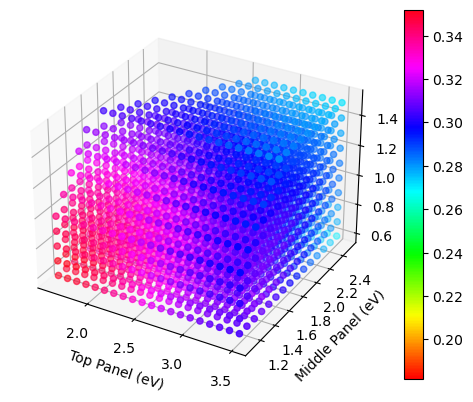

In [16]:

from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
import scipy.interpolate
import matplotlib.cm as cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import pandas as pd









xi = outdf['cell 1']
yi = outdf['cell 2']
zi = outdf['cell 3']
ei = outdf['eff']


fig = plt.figure()

ax = fig.add_subplot(111,projection='3d')


colmap = cm.ScalarMappable(cmap=cm.hsv)
colmap.set_array(ei)


yg = ax.scatter(xi, yi, zi, c=cm.hsv(ei/max(ei)), marker='o')
cb = fig.colorbar(colmap)

ax.set_xlabel('Top Panel (eV)')
ax.set_ylabel('Middle Panel (eV)')
ax.set_zlabel('Lower Panel (eV)')


plt.show()

In [17]:
from sqlalchemy import create_engine

engine = create_engine('sqlite://', echo=False)

In [18]:
outdf.to_sql('results', con=engine)

engine.execute("SELECT * FROM results WHERE eff > .3").fetchall()


[(1322, 2.599999999999999, 1.4999999999999991, 0.6999999999999993, 293.3926270691614, 0.30005382191568974),
 (1330, 2.599999999999999, 1.399999999999999, 0.6999999999999993, 297.6935143829398, 0.30445235670171794),
 (1337, 2.599999999999999, 1.299999999999999, 0.6999999999999993, 295.960572609076, 0.3026800701667785),
 (1343, 2.599999999999999, 1.1999999999999988, 0.6999999999999993, 294.8524883626926, 0.30154682794302784),
 (1445, 2.499999999999999, 1.4999999999999991, 0.8999999999999995, 296.20858354463496, 0.30293371194992325),
 (1446, 2.499999999999999, 1.4999999999999991, 0.7999999999999994, 293.8886986999634, 0.3005611563714087),
 (1447, 2.499999999999999, 1.4999999999999991, 0.6999999999999993, 298.8809942361988, 0.3056667971325412),
 (1453, 2.499999999999999, 1.399999999999999, 0.8999999999999995, 298.6471607761405, 0.3054276547107184),
 (1454, 2.499999999999999, 1.399999999999999, 0.7999999999999994, 297.46874683836995, 0.3042224860281959),
 (1455, 2.499999999999999, 1.3999999